In [1]:
import numpy as np
import import_ipynb
from lib.draw import board_to_svg
from IPython.display import SVG

importing Jupyter notebook from /home/nikita/Code/Thesis/source/lib/draw.ipynb


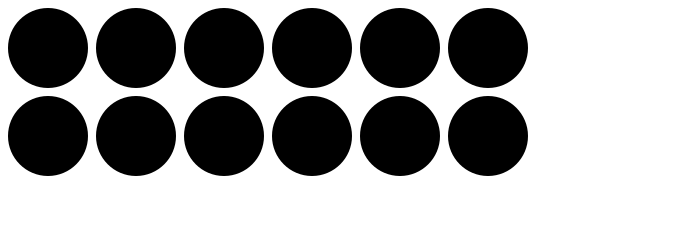

In [2]:
board = np.full((2, 6), 4)
SVG(board_to_svg(board))

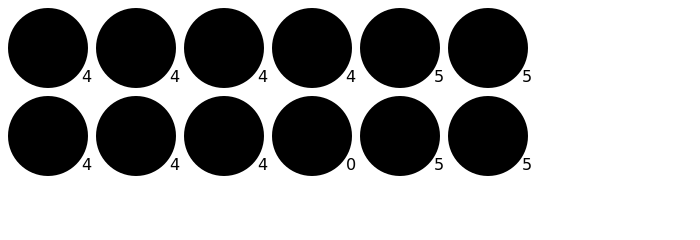

In [3]:
board = np.array([
    [4, 4, 4, 4, 5, 5],
    [4, 4, 4, 0, 5, 5],
])
SVG(board_to_svg(board, True,highlight=[(1, 3)]))

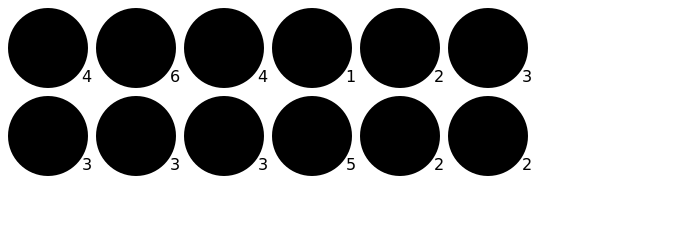

In [4]:
board = np.array([
    [4, 6, 4, 1, 2, 3],
    [3, 3, 3, 5, 2, 2],
])
SVG(board_to_svg(board, True,highlight=[(1, 3)]))

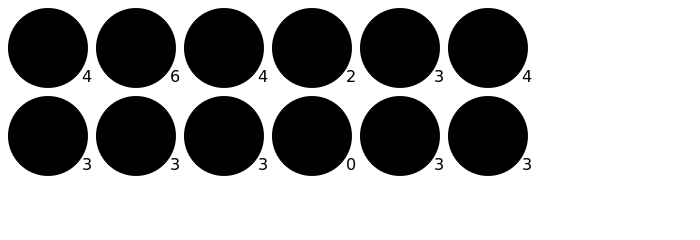

In [5]:
board = np.array([
    [4, 6, 4, 2, 3, 4],
    [3, 3, 3, 0, 3, 3],
])
SVG(board_to_svg(board, True,highlight=[(0, 3), (0, 4)]))

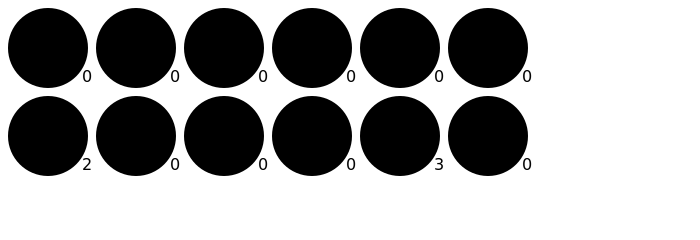

In [6]:
board = np.array([
    [0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 3, 0],
])
SVG(board_to_svg(board, True,highlight=[(1, 4)]))

In [ ]:
import numpy as np
import itertools
from recordclass import recordclass

import import_ipynb
from draw import board_to_svg

In [78]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class Game:
    pits: np.array
    current_player: int
    captures: Tuple[int, int]

In [79]:
class Game(Game):
    ...
    
    @classmethod
    def new(klass):
        return klass(
            # A 6x2 matrix filled with 4
            pits=np.ones(6 * 2, dtype=int) * 4,
            current_player=0,
            captures=(0, 0)
        )

In [80]:
class Game(Game):
    ...

    @property
    def view_from_current_player(self):
        if self.current_player == 0:
            return self.pits
        else:
            return np.roll(self.pits, 6)
    
    @property
    def current_player_pits(self):
        if self.current_player == 0:
            return self.pits[:6]
        else:
            return self.pits[6:]

    @property
    def current_opponent(self):
        return (self.current_player + 1) % 2
    
    @property
    def adverse_pits_idx(self):
        if self.current_player == 1:
            return list(range(6))
        else:
            return list(range(6, 6 * 2))
    

In [81]:
class Game(Game):
    ...
    
    @property
    def legal_actions(self):
        our_pits = self.current_player_pits
        return [x for x in range(6) if our_pits[x] != 0]
    
    @property
    def game_finished(self):
        no_moves_left = np.sum(self.current_player_pits) == 0
        
        half_seeds = 6 * 4
        enough_captures = self.captures[0] > half_seeds or self.captures[1] > half_seeds
        
        draw = self.captures[0] == half_seeds and self.captures[1] == half_seeds
        
        return no_moves_left or enough_captures or draw
    
    @property
    def winner(self):
        if not self.game_finished:
            return None
        return np.argmax(self.captures)

In [82]:
class Game(Game):
    ...
    
    def step(self, action):
        assert 0 <= action < 6, "Illegal action"
        
        target_pit = action if self.current_player == 0 else action - 6
        
        seeds = self.pits[target_pit]
        assert seeds != 0, "Illegal action: pit % is empty" % target_pit
        
        # copy attributes
        pits = np.copy(self.pits)
        captures = np.copy(self.captures)
        
        # empty the target pit
        pits[target_pit] = 0
        
        # fill the next pits
        pit_to_sow = target_pit
        while seeds > 0:
            pit_to_sow = (pit_to_sow + 1) % (6 * 2)
            if pit_to_sow != target_pit: # do not fill the target pit ever
                pits[pit_to_sow] += 1
                seeds -= 1
        
        # Capture
        # -------
        
        # count the captures of the play
        round_captures = 0
        if pit_to_sow in self.adverse_pits_idx:
            # if the last seed was in a adverse pit
            # we can try to collect seeds
            while pits[pit_to_sow] in (2, 3):
                # if the pit contains 2 or 3 seeds, we capture them
                captures[self.current_player] += pits[pit_to_sow]
                round_captures += pits[pit_to_sow]
                pits[pit_to_sow] = 0
                
                # go backwards
                pit_to_sow = (pit_to_sow - 1) % (self.n_pits * 2)
        
        # change player
        current_player = (self.current_player + 1) % 2
        
        new_game = type(self)(
            pits,
            current_player,
            captures
        )

        return new_game, round_captures, new_game.game_finished


In [88]:
class Game(Game):
    ...
    
    def show_state(self):
        if self.game_finished:
            print("Game finished")
        print("Current player: {} - Score: {}/{}\n{}".format(
            self.current_player,
            self.captures[self.current_player],
            self.captures[(self.current_player + 1) % 2],
            "-" * self.n_pits * 3
        ))
        
        pits = []
        for seeds in self.view_from_current_player:
            pits.append("{:3}".format(seeds))
        
        print("".join(reversed(pits[self.n_pits:])))
        print("".join(pits[:self.n_pits]))

    def __repr__(self):
        return "<Game current_player:{player} captures:{captures[0]}/{captures[1]}>".format(
            player=self.current_player,
            captures=self.captures
        )
    
    def _repr_svg_(self):
        board = np.array([
            list(reversed(self.pits[6:])),
            self.pits[:6]
        ])
        return board_to_svg(board, True)

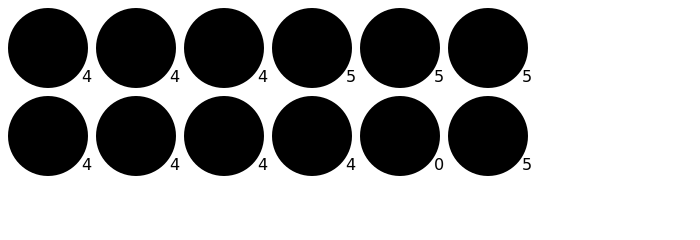

In [89]:
g = Game.new()
g, captures, done = g.step(4)
g

In [99]:
from typing import Optional, List
from dataclasses import field

@dataclass
class TreeGame(Game):
    parent: Optional[Game] = None
    children: List[Optional[Game]] = field(default_factory=lambda: [None] * 6)

In [102]:
class TreeGame(TreeGame):
    ...
    
    def step(self, action):
        # If we already did compute the children node, juste return it
        if self.children[action] is not None:
            new_game = self.children[action]
            captures = new_game.captures[self.current_player] - self.captures[self.current_player]
            return new_game, captures, new_game.game_finished
        else:
            new_game, captures, finished = super().step(action)
            new_game.parent = self
            return new_game, captures, finished

In [ ]:
class TreeGame(TreeGame):
    ...

    @property
    def successors(self):
        children = [x for x in self.children if x is not None]
        successors = children + list(itertools.chain(*[x.successors for x in children]))
        return successors
    
    @property
    def unvisited_actions(self):
        return [i for i, x in enumerate(self.children) if x is None]

    @property
    def legal_unvisited_actions(self):
        return list(set(self.unvisited_actions).intersection(set(self.legal_actions)))
    
    @property
    def expanded_children(self):
        return [x for x in self.children if x is not None]
    
    @property
    def is_fully_expanded(self):
        legal_actions = set(self.legal_actions)
        unvisited_actions = set(self.unvisited_actions)
        return len(legal_actions.intersection(unvisited_actions)) == 0
    
    @property
    def is_leaf_game(self):
        return self.children == [None] * 6
    
    @property
    def depth(self):
        if self.parent is None:
            return 0
        return 1 + self.parent.depth

In [110]:
class TreeGame(TreeGame):
    ...
    
    def update_stats(self, winner):
        assert winner in [0, 1]
        self.wins[winner] += 1
        self.n_playouts += 1
        if self.parent:
            self.parent.update_stats(winner)